# Loss Manifold Analysis
---

This notebook analyses the a 2D cost manifold of $D_I$, $D_q$ and $D_u$ for AirMSPI polarized bands and wavelengths. The cloud is a homogeneous cube and a is function of 2-parameters: ${\rm LWC}, r_e$.

In [29]:
"""
Imports and general setting for this notebook 
"""
import os
import numpy as np
import shdom
from tqdm import tqdm_notebook
import itertools
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Change directory to pyshdom main directory
if os.getcwd().endswith('notebooks'):
    %cd '../'

In [2]:
"""
Function definitions
"""    
def generate_measurements(wavelength, lwc, reff, view_zenith, view_azimuth, 
                          solar_zenith, solar_azimuth, veff=0.1, n_jobs=35):
    """
    This function uses the render_polarization_toa script 
    to render a grid of measurements across microphysical parameters.
    The medium is a 1x1x20km atmosphere with rayleigh scattering and a single cloudy voxel in the center.
    
    Parameters
    ----------
    wavelength: list or np.array
        a list or array of wavelengths
    lwc: list or np.array
        a list or array of liquid water content.
    reff: list or np.array
        a list or array of effective radii
    view_zenith: float, list or np.array
        a list or array of view zenith angles
    view_azimuth: float, list or np.array
        The view azimuth angles
    solar_zenith: float, list or np.array
        a list or array of solar zenith angles
    solar_azimuth: float, list or np.array
        The solar azimuth angles
    veff: float
        The effective variance. Default is 0.1.
    n_jobs: int
        The number of jobs to parallelize across.
        
    Returns
    -------
    stokes: np.array(shape=(num_stokes, num_pixels, num_wavelength, num_lwc, num_reff))
        A multi-dimensional array containing a grid of measurements. 
    """
    from scripts.render_polarization_toa import RenderScript
    
    wavelength = [str(i) for i in np.atleast_1d(wavelength)]
    view_zenith = [str(i) for i in np.atleast_1d(view_zenith)] 
    view_azimuth = [str(i) for i in np.atleast_1d(view_azimuth)] 
    solar_zenith = np.atleast_1d(solar_zenith)
    solar_azimuth = np.atleast_1d(solar_azimuth)
    
    if len(view_zenith)!=len(view_azimuth):
        if len(view_zenith)==1 and len(view_azimuth)>1:
            view_zenith = solar_zenith * len(view_azimuth)
        elif len(view_azimuth)==1 and len(view_zenith)>1:
            view_azimuth = view_azimuth * len(view_zenith)
        else:
            raise AttributeError('error dimensions for solar zenith or azimuth')

    if len(solar_zenith)!=len(solar_azimuth):
        if len(solar_zenith)==1 and len(solar_azimuth)>1:
            solar_zenith = np.full_like(solar_azimuth, solar_zenith)
        elif len(solar_azimuth)==1 and len(solar_zenith)>1:
            solar_azimuth = np.full_like(solar_zenith, solar_azimuth)
        else:
            raise AttributeError('error dimensions for solar zenith or azimuth')

    num_wavelengths = len(wavelength)
    reff = np.atleast_1d(reff)
    lwc = np.atleast_1d(lwc)
    num_reff = len(reff)
    num_lwc = len(lwc)
    num_solar = len(solar_azimuth)
    
    render_script = RenderScript()
    sys.argv = ['', ''] + wavelength + ['--generator', 'SingleVoxel'] + ['--x_res', '0.01'] + \
               ['--y_res', '0.01'] + ['--domain_size', '1.0', '--nx', '5', '--ny', '5'] + \
               ['--azimuth'] + view_azimuth + ['--zenith'] + view_zenith + \
               ['--n_jobs', str(n_jobs), '--veff', str(veff)] + ['--add_rayleigh']
    render_script.parse_arguments()
    
    lwc_reff_list = list(itertools.product(lwc, reff, zip(solar_zenith, solar_azimuth)))
    total_size = len(lwc_reff_list)
    if n_jobs < total_size:
        split_list = np.array_split(lwc_reff_list, int(total_size/n_jobs))
    else:
        split_list = [lwc_reff_list]
    
    stokes = []
    for split_list in tqdm_notebook(split_list):
        rte_solvers = shdom.RteSolverArray()
        if isinstance(split_list, tuple):
            split_list = [split_list]
        for lwc, reff, (solar_zenith, solar_azimuth) in split_list:
            render_script.args.reff = reff
            render_script.args.lwc = lwc
            render_script.args.solar_zenith = solar_zenith
            render_script.args.solar_azimuth = solar_azimuth
            medium = render_script.get_medium()
            rte_solvers.add_solver(render_script.get_solver(medium))
        rte_solvers.solve(maxiter=100, verbose=True)
        measurements = render_script.render(medium.get_scatterer('cloud').bounding_box, rte_solvers)
        stokes.append(measurements.pixels)
    stokes = np.concatenate(stokes, axis=-1)
    return stokes.reshape(stokes.shape[0:2] + (-1, num_solar, num_reff, num_lwc), order='F')

def generate_loss_manifold(stokes_grid, stokes_true, index):
    """
    Compute the L2 loss on a grid for one of the stokes components.
    
    Parameters
    ----------
    stokes_grid: np.array(shape=(num_stokes, num_pixels, num_wavelength, num_lwc, num_reff))
        A multi-dimensional array containing a grid of measurements.
    stokes_true: np.array(shape=(num_stokes, num_pixels, num_wavelength, 1, 1))
        A multi-dimensional array containing the ground truth measurements.
    index: int
        An integer in the range [0, 2]:
          0: compute I loss manifold
          1: compute Q loss manifold
          2: compute U loss manifold
          
    Returns
    -------
    loss: np.array(shape=(num_lwc, num_reff))
        The component loss manifold.
    """
    loss = np.linalg.norm(
        stokes_grid[index].reshape(-1, stokes_grid.shape[-2], stokes_grid.shape[-1]) - \
        stokes_true[index].reshape(-1, stokes_true.shape[-2], stokes_true.shape[-1]), axis=0)**2
    return loss

"""
Define AirMSPI zenith angles and polarization bands, flight direction, solar angles
"""
view_zenith = [70.5, 65, 45.6, 26.1, 0.0, -26.1, -45.6, -65, -70.5]
view_azimuth = 0.0
wavelengths = [0.47, 0.66, 0.865]

# Solar parameters
solar_azimuth = [0, 22.5, 45, 67.5, 90]
solar_zenith = 165.0

## Generate measurement grid

In [ ]:
"""
This main polarization rendering procedure 
It takes ~1.75 hours for 50x50 (lwc, reff) grid and n_jobs=30

Notes
-----
This cell should be ran with POLARIZATION compilation flag set to True
"""
# safe creation of a directory to save results
directory = 'microphysical_loss_analysis/airmspi/' 
if not os.path.exists(directory):
    os.makedirs(directory)

# Microphysical grid definition
reff_range = np.linspace(6.0, 18.5, 50)
lwc_range = np.linspace(1e-2, 0.85, 50)

# Run and save the results
stokes = generate_measurements(wavelengths, lwc_range, reff_range, 
                               view_zenith, view_azimuth, solar_zenith, solar_azimuth)
path = os.path.join(directory, 'Stokes{}x{}.npz'.format(len(lwc_range), len(reff_range)))
np.savez(path, stokes=stokes, reff_range=reff_range, lwc_range=lwc_range)

## Load measuremet grid

In [3]:
"""
Load measurement grid from a pre-computed saved file
"""
data = np.load('microphysical_loss_analysis/airmspi/Stokes50x50.npz')
stokes, lwc_range, reff_range  = data['stokes'], data['lwc_range'], data['reff_range']

## Plot manifold

In [5]:
"""
Matplotlib definitions and imports.
Compute the loss manifolds for the "True" measurements (local minimum).
"""
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'

lwc_true, reff_true = 0.356,  12.34
stokes_true = generate_measurements(wavelengths, lwc_true, reff_true, 
                                    view_zenith, view_azimuth, solar_zenith, solar_azimuth)
loss = dict()
for i, component in enumerate(['I', 'Q', 'U']):
    loss[component] = []
    for j in range(len(solar_azimuth)):
        loss[component].append(generate_loss_manifold(stokes[:,:,:,j], stokes_true[:,:,:,j], i))

Reading mie table from file: mie_tables/polydisperse/Water_470nm.scatpol
Reading mie table from file: mie_tables/polydisperse/Water_660nm.scatpol
Reading mie table from file: mie_tables/polydisperse/Water_865nm.scatpol


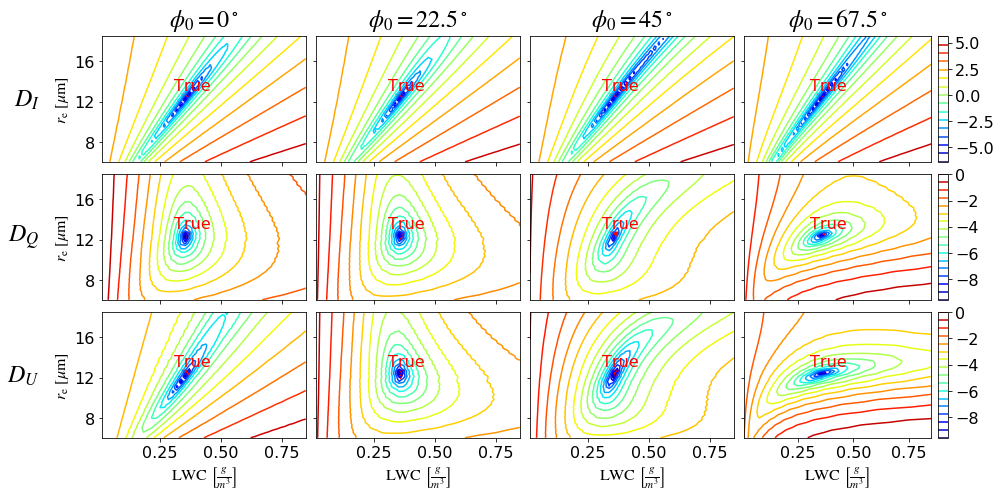

In [6]:
"""
Plot and save the manifolds for several solar azimuths
"""
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

fig, axes = plt.subplots(3, 4, figsize=(14, 7), sharex=True, sharey=True)
x, y = np.meshgrid(lwc_range, reff_range, indexing='ij')
for i, (component, loss_manifold) in enumerate(loss.items()):
    for j in range(len(azimuth)):
        c = axes[i,j].contour(x, y, np.log(loss_manifold[j]).T, cmap=plt.get_cmap('jet'), levels=15)
        axes[i,j].scatter(lwc_true, reff_true, marker='v', color='r', s=80)
        axes[i,j].text(lwc_true - 0.05, reff_true + 0.8, 'True', color='r', fontsize=16)
        axes[2,j].set_xlabel(r'${\rm LWC}~\left[\frac{g}{m^3}\right]$', fontsize=16)
    divider = make_axes_locatable(axes[i,3])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(c, cax=cax)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    axes[i,0].set_ylabel(r'$r_{\rm e}~\left[\mu {\rm m}\right]$', fontsize=16)  
    axes[i,0].set_yticks([8, 12, 16])
       
for ax, azimuth in zip(axes[0], solar_azimuth):
    ax.annotate(r'$\phi_0 = {}^\circ$'.format(azimuth), xy=(0.5, 1), xytext=(0, 10),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', fontsize=24)

for ax, component in zip(axes[:,0], list(loss.keys())):
    ax.annotate(r'$D_{}$'.format(component), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 10, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', fontsize=24)

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.1)